In [30]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as stats 
import statistics 

import warnings 
warnings.filterwarnings('ignore')

In [31]:
#!pip install geopy
from geopy.distance import geodesic
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV 
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LinearRegression 
from sklearn.tree import DecisionTreeRegressor 
from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import xgboost as xgb

# 1. Data loading 

In [32]:
df_train = pd.read_csv('data/train.csv')
print(df_train.shape)
df_train.head()

(45593, 20)


,ID,Delivery_person_ID,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weatherconditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min)
0,0x4607,INDORES13DEL02,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,conditions Sunny,High,2,Snack,motorcycle,0,No,Urban,(min) 24
1,0xb379,BANGRES18DEL02,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,conditions Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,(min) 33
2,0x5d6d,BANGRES19DEL01,23,4.4,12.914264,77.678400,12.924264,77.688400,19-03-2022,08:30:00,08:45:00,conditions Sandstorms,Low,0,Drinks,motorcycle,1,No,Urban,(min) 26
3,0x7a6a,COIMBRES13DEL02,38,4.7,11.003669,76.976494,11.053669,77.026494,05-04-2022,18:00:00,18:10:00,conditions Sunny,Medium,0,Buffet,motorcycle,1,No,Metropolitian,(min) 21
4,0x70a2,CHENRES12DEL01,32,4.6,12.972793,80.249982,13.012793,80.289982,26-03-2022,13:30:00,13:45:00,conditions Cloudy,High,1,Snack,scooter,1,No,Metropolitian,(min) 30


In [33]:
df_train.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weatherconditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [34]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   ID                           45593 non-null  object 
 1   Delivery_person_ID           45593 non-null  object 
 2   Delivery_person_Age          45593 non-null  object 
 3   Delivery_person_Ratings      45593 non-null  object 
 4   Restaurant_latitude          45593 non-null  float64
 5   Restaurant_longitude         45593 non-null  float64
 6   Delivery_location_latitude   45593 non-null  float64
 7   Delivery_location_longitude  45593 non-null  float64
 8   Order_Date                   45593 non-null  object 
 9   Time_Orderd                  45593 non-null  object 
 10  Time_Order_picked            45593 non-null  object 
 11  Weatherconditions            45593 non-null  object 
 12  Road_traffic_density         45593 non-null  object 
 13  Vehicle_conditio

In [35]:
df_train.describe().T

,count,mean,std,min,25%,50%,75%,max
Restaurant_latitude,45593.0,17.017729,8.185109,-30.905562,12.933284,18.546947,22.728163,30.914057
Restaurant_longitude,45593.0,70.231332,22.883647,-88.366217,73.170000,75.898497,78.044095,88.433452
Delivery_location_latitude,45593.0,17.465186,7.335122,0.010000,12.988453,18.633934,22.785049,31.054057
Delivery_location_longitude,45593.0,70.845702,21.118812,0.010000,73.280000,76.002574,78.107044,88.563452
Vehicle_condition,45593.0,1.023359,0.839065,0.000000,0.000000,1.000000,2.000000,3.000000


In [36]:
## 숫자 타입이 아닌 다른 변수들도 살펴보자 
df_train.describe(exclude=np.number).T

,count,unique,top,freq
ID,45593,45593,0x8e91,1
Delivery_person_ID,45593,1320,PUNERES01DEL01,67
Delivery_person_Age,45593,23,35,2262
Delivery_person_Ratings,45593,29,4.8,7148
Order_Date,45593,44,15-03-2022,1192
Time_Orderd,45593,177,NaN,1731
Time_Order_picked,45593,193,21:30:00,496
Weatherconditions,45593,7,conditions Fog,7654
Road_traffic_density,45593,5,Low,15477
Type_of_order,45593,4,Snack,11533


- numeric & category 변수가 혼합되어 있다. 
- Time_Orderd 변수에는 다수의 NaN 값이 존재한다. 
- Weatherconditions(ex.conditions Sunny), Time_taken(min)(ex.(min) 24) 변수는 전처리가 필요해 보인다. 

In [37]:
## each columns details 
for columns in df_train.columns : 
    print(columns)
    print(df_train[columns].value_counts())
    print('-------------------------------------------------')

ID
0x8e91     1
0x729e     1
0x2ded     1
0x7877     1
0x3c08     1
          ..
0x56cb     1
0x6922     1
0xa21d     1
0x19ea     1
0x5184     1
Name: ID, Length: 45593, dtype: int64
-------------------------------------------------
Delivery_person_ID
PUNERES01DEL01       67
JAPRES11DEL02        67
RANCHIRES02DEL01     66
JAPRES03DEL01        66
VADRES08DEL02        66
                     ..
AURGRES11DEL03        7
AURGRES13DEL03        7
KOCRES16DEL03         6
KOLRES09DEL03         6
BHPRES010DEL03        5
Name: Delivery_person_ID, Length: 1320, dtype: int64
-------------------------------------------------
Delivery_person_Age
35      2262
36      2260
37      2227
30      2226
38      2219
24      2210
32      2202
22      2196
29      2191
33      2187
28      2179
25      2174
34      2166
26      2159
21      2153
27      2150
39      2144
20      2136
31      2120
23      2087
NaN     1854
50        53
15        38
Name: Delivery_person_Age, dtype: int64
---------------------

# 2. Data Cleaning

In [38]:
## 컬럼명 바꾸기 
def update_column_name(df): 
    df.rename(columns = {'Weatherconditions': 'Weather_conditions'}, inplace=True)
    
update_column_name(df_train)
df_train.columns

Index(['ID', 'Delivery_person_ID', 'Delivery_person_Age',
       'Delivery_person_Ratings', 'Restaurant_latitude',
       'Restaurant_longitude', 'Delivery_location_latitude',
       'Delivery_location_longitude', 'Order_Date', 'Time_Orderd',
       'Time_Order_picked', 'Weather_conditions', 'Road_traffic_density',
       'Vehicle_condition', 'Type_of_order', 'Type_of_vehicle',
       'multiple_deliveries', 'Festival', 'City', 'Time_taken(min)'],
      dtype='object')

In [39]:
df_train['Time_taken(min)'][:5]

0    (min) 24
1    (min) 33
2    (min) 26
3    (min) 21
4    (min) 30
Name: Time_taken(min), dtype: object

In [40]:
## Time_taken(min) --> 앞부분 (min)을 없애야 한다. 
## Weather_conditions --> 앞부분 conditions 없앤다. 
## Delivery_person_ID --> RES 앞부분이 도시명을 나타낸다.

df_train[['Time_taken(min)', 'Weather_conditions', 'Delivery_person_ID']].head()

,Time_taken(min),Weather_conditions,Delivery_person_ID
0,(min) 24,conditions Sunny,INDORES13DEL02
1,(min) 33,conditions Stormy,BANGRES18DEL02
2,(min) 26,conditions Sandstorms,BANGRES19DEL01
3,(min) 21,conditions Sunny,COIMBRES13DEL02
4,(min) 30,conditions Cloudy,CHENRES12DEL01


In [41]:
def extract_column_value(df): 
    df['Time_taken(min)'] = df['Time_taken(min)'].apply(lambda x: int(x.split(' ')[1].strip()))
    df['Weather_conditions'] = df['Weather_conditions'].apply(lambda x: x.split(' ')[1].strip())
    df['City_code'] = df['Delivery_person_ID'].str.split('RES', expand=True)[0]
    
extract_column_value(df_train)    
df_train[['Time_taken(min)', 'Weather_conditions', 'City_code']].head()

,Time_taken(min),Weather_conditions,City_code
0,24,Sunny,INDO
1,33,Stormy,BANG
2,26,Sandstorms,BANG
3,21,Sunny,COIMB
4,30,Cloudy,CHEN


In [42]:
## 불필요한 컬럼 drop 
def drop_columns(df): 
    df.drop(['ID', 'Delivery_person_ID'], axis=1, inplace = True) 
    
drop_columns(df_train)
df_train.head(2)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code
0,37,4.9,22.745049,75.892471,22.765049,75.912471,19-03-2022,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0,No,Urban,24,INDO
1,34,4.5,12.913041,77.683237,13.043041,77.813237,25-03-2022,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1,No,Metropolitian,33,BANG


In [43]:
## 혹시 DB 오류로 중복된 값이 있는지 확인해보기 
if(len(df_train[df_train.duplicated()]) > 0): 
    print('Duplicated Values exist.')
else :
    print('NO Duplicated Values.')

NO Duplicated Values.


In [44]:
## data type 변경 
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Delivery_person_Age          45593 non-null  object 
 1   Delivery_person_Ratings      45593 non-null  object 
 2   Restaurant_latitude          45593 non-null  float64
 3   Restaurant_longitude         45593 non-null  float64
 4   Delivery_location_latitude   45593 non-null  float64
 5   Delivery_location_longitude  45593 non-null  float64
 6   Order_Date                   45593 non-null  object 
 7   Time_Orderd                  45593 non-null  object 
 8   Time_Order_picked            45593 non-null  object 
 9   Weather_conditions           45593 non-null  object 
 10  Road_traffic_density         45593 non-null  object 
 11  Vehicle_condition            45593 non-null  int64  
 12  Type_of_order                45593 non-null  object 
 13  Type_of_vehicle 

In [45]:
def update_datatype(df) : 
    df['Delivery_person_Age'] = df['Delivery_person_Age'].astype('float64')
    df['Delivery_person_Ratings'] = df['Delivery_person_Ratings'].astype('float64')
    df['Order_Date'] = pd.to_datetime(df['Order_Date'], format = '%d-%m-%Y')
    df['multiple_deliveries'] = df['multiple_deliveries'].astype('float64')
    
update_datatype(df_train)
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45593 entries, 0 to 45592
Data columns (total 19 columns):
 #   Column                       Non-Null Count  Dtype         
---  ------                       --------------  -----         
 0   Delivery_person_Age          43739 non-null  float64       
 1   Delivery_person_Ratings      43685 non-null  float64       
 2   Restaurant_latitude          45593 non-null  float64       
 3   Restaurant_longitude         45593 non-null  float64       
 4   Delivery_location_latitude   45593 non-null  float64       
 5   Delivery_location_longitude  45593 non-null  float64       
 6   Order_Date                   45593 non-null  datetime64[ns]
 7   Time_Orderd                  45593 non-null  object        
 8   Time_Order_picked            45593 non-null  object        
 9   Weather_conditions           45593 non-null  object        
 10  Road_traffic_density         45593 non-null  object        
 11  Vehicle_condition            45593 non-nu

In [46]:
## 'NaN'을 null값으로 인식시켜서, 실제 null값이 얼마나 되는지 확인하기 
def convert_nan(df): 
    df.replace('NaN', float(np.nan), regex=True, inplace = True)
    
convert_nan(df_train)
df_train.isnull().sum().sort_values(ascending=False)

Delivery_person_Ratings        1908
Delivery_person_Age            1854
Time_Orderd                    1731
City                           1200
multiple_deliveries             993
Weather_conditions              616
Road_traffic_density            601
Festival                        228
Order_Date                        0
Delivery_location_longitude       0
Time_Order_picked                 0
Delivery_location_latitude        0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
Restaurant_longitude              0
Restaurant_latitude               0
Time_taken(min)                   0
City_code                         0
dtype: int64

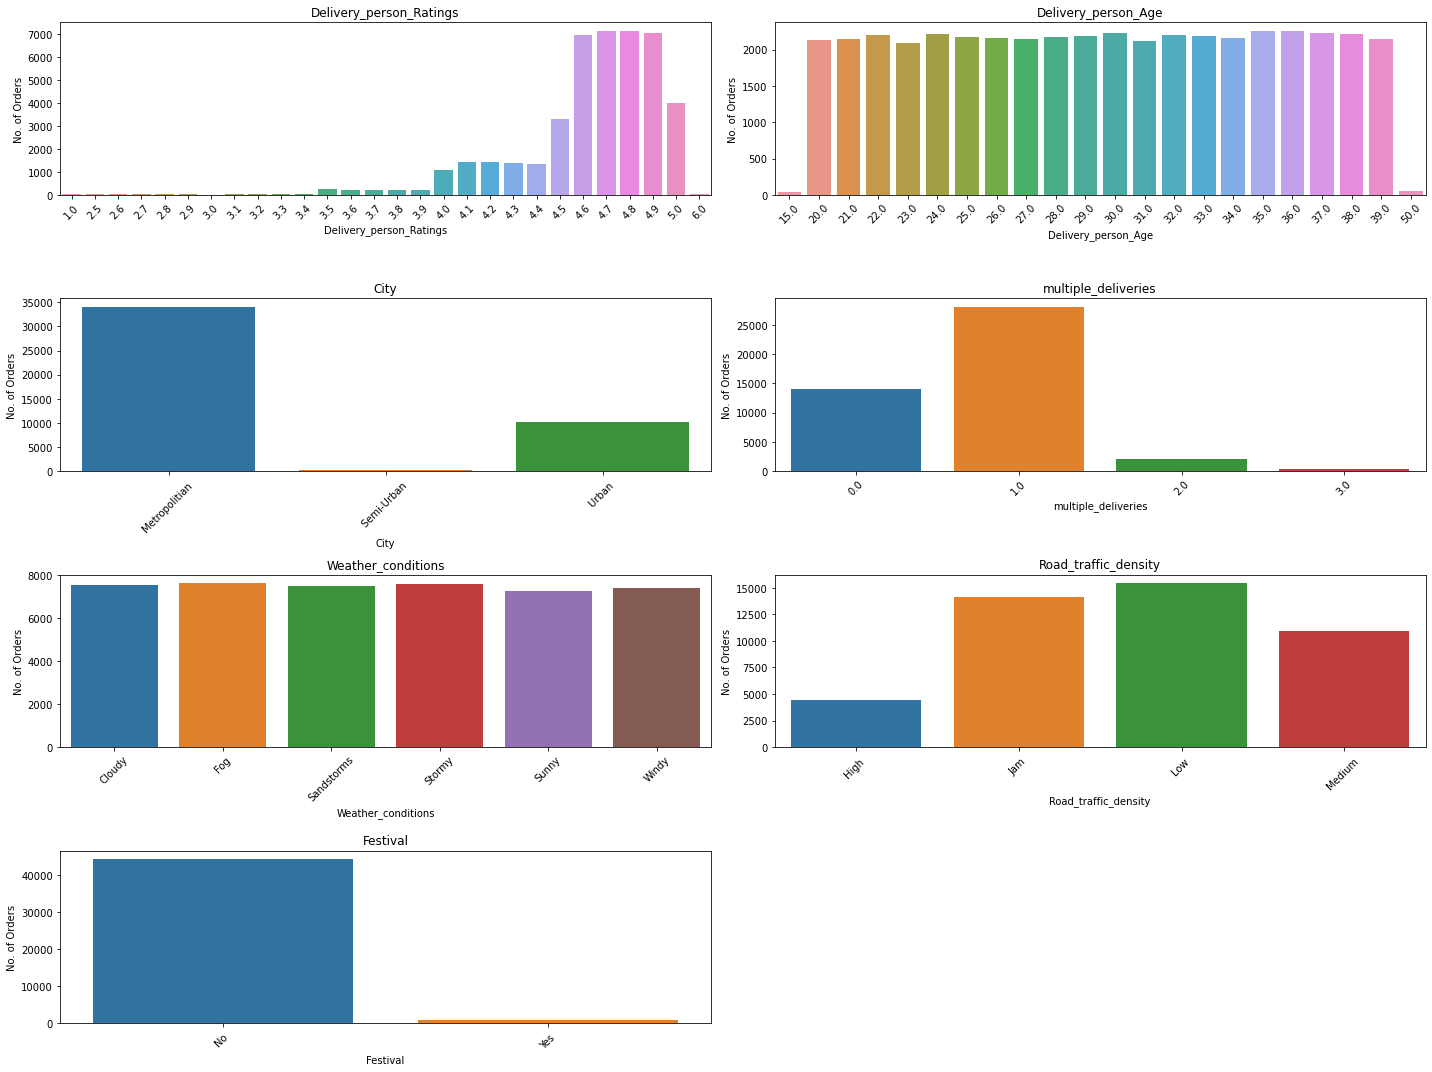

In [47]:
## null값 처리를 위해, 해당 컬럼들을 자세히 살펴본다.  
cols = ['Delivery_person_Ratings', 'Delivery_person_Age', 'City', 'multiple_deliveries', 'Weather_conditions','Road_traffic_density','Festival']        
num_plots = len(cols)
num_rows = (num_plots //2) + (num_plots %2)

fig, axes = plt.subplots(num_rows, 2, figsize=(20,15))

for i, column_name in enumerate(cols):
    row = i // 2
    col = i % 2

    ax = axes[row, col]
    sns.countplot(data=df_train, x=column_name, order=df_train[column_name].value_counts().sort_index().index, ax=ax)

    ax.set_xlabel(column_name)
    ax.set_ylabel('No. of Orders')
    ax.set_title(column_name)
    ax.tick_params(axis='x', rotation=45)
    
if num_plots % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.tight_layout()
plt.show()

In [48]:
## Delivery_person_Age, Weather_conditions --> 랜덤값으로 대체 
## City, Festival, multiple_deliveries, Road_traffic_density --> 가장 많은 값으로 대체 
## Delivery_person_Ratings --> 중앙값으로 대체 

def handle_null_values(df):
    df['Delivery_person_Age'].fillna(np.random.choice(df['Delivery_person_Age']), inplace=True)
    df['Weather_conditions'].fillna(np.random.choice(df['Weather_conditions']), inplace=True)
    df['City'].fillna(df['City'].mode()[0], inplace=True)
    df['Festival'].fillna(df['Festival'].mode()[0], inplace=True)
    df['multiple_deliveries'].fillna(df['multiple_deliveries'].mode()[0], inplace=True)
    df['Road_traffic_density'].fillna(df['Road_traffic_density'].mode()[0], inplace=True)
    df['Delivery_person_Ratings'].fillna(df['Delivery_person_Ratings'].median(), inplace=True)
    
handle_null_values(df_train)
df_train.isnull().sum()

Delivery_person_Age               0
Delivery_person_Ratings           0
Restaurant_latitude               0
Restaurant_longitude              0
Delivery_location_latitude        0
Delivery_location_longitude       0
Order_Date                        0
Time_Orderd                    1731
Time_Order_picked                 0
Weather_conditions                0
Road_traffic_density              0
Vehicle_condition                 0
Type_of_order                     0
Type_of_vehicle                   0
multiple_deliveries               0
Festival                          0
City                              0
Time_taken(min)                   0
City_code                         0
dtype: int64

# 3. Feature engineering 

In [49]:
## Order_Date 변수로부터 필요한 날짜관련 정보들 추출
def extract_date_features(data): 
    data['day'] = data.Order_Date.dt.day
    data['month'] = data.Order_Date.dt.month
    data['quarter'] = data.Order_Date.dt.quarter
    data['year'] = data.Order_Date.dt.year
    
    data['day_of_week'] = data.Order_Date.dt.day_of_week.astype(int)
    
    data['is_month_start'] = data.Order_Date.dt.is_month_start.astype(int)
    data['is_month_end'] = data.Order_Date.dt.is_month_end.astype(int)
    data['is_quarter_start'] = data.Order_Date.dt.is_quarter_start.astype(int)
    data['is_quarter_end'] = data.Order_Date.dt.is_quarter_end.astype(int)
    data['is_year_start'] = data.Order_Date.dt.is_year_start.astype(int)
    data['is_year_end'] = data.Order_Date.dt.is_year_end.astype(int)
    
    data['is_weekend'] = np.where(data['day_of_week'].isin([5,6]), 1, 0)
    
extract_date_features(df_train)    
df_train.head(3)

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Order_Date,Time_Orderd,Time_Order_picked,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,2022-03-19,11:30:00,11:45:00,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,1,2022,5,0,0,0,0,0,0,1
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,2022-03-25,19:45:00,19:50:00,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,1,2022,4,0,0,0,0,0,0,0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2022-03-19,08:30:00,08:45:00,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,1,2022,5,0,0,0,0,0,0,1


In [50]:
## order -> pick 경과시간 구하기 
def calculate_time_diff(df):
    # Find the difference between ordered time & picked time
    df['Time_Orderd'] = pd.to_timedelta(df['Time_Orderd'])
    df['Time_Order_picked'] = pd.to_timedelta(df['Time_Order_picked'])
    
    df['Time_Order_picked_formatted'] = df['Order_Date'] + np.where(df['Time_Order_picked'] < df['Time_Orderd'], pd.DateOffset(days=1), pd.DateOffset(days=0)) + df['Time_Order_picked']
    df['Time_Ordered_formatted'] = df['Order_Date'] + df['Time_Orderd']
    
    df['order_prepare_time'] = (df['Time_Order_picked_formatted'] - df['Time_Ordered_formatted']).dt.total_seconds() / 60
    
    # Handle null values by filling with the median
    df['order_prepare_time'].fillna(df['order_prepare_time'].median(), inplace=True)
    
    # Drop all the time & date related columns
    df.drop(['Time_Orderd', 'Time_Order_picked', 'Time_Ordered_formatted', 'Time_Order_picked_formatted', 'Order_Date'], axis=1, inplace=True)


calculate_time_diff(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,1,2022,5,0,0,0,0,0,0,1,15.0
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,1,2022,4,0,0,0,0,0,0,0,5.0
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,1,2022,5,0,0,0,0,0,0,1,15.0
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2,2022,1,0,0,0,0,0,0,0,10.0
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,1,2022,5,0,0,0,0,0,0,1,15.0


In [51]:
## 식당 -> 배달처간 거리 구하기  
def calculate_distance(df):
    df['distance']=np.zeros(len(df))
    restaurant_coordinates=df[['Restaurant_latitude','Restaurant_longitude']].to_numpy()
    delivery_location_coordinates=df[['Delivery_location_latitude','Delivery_location_longitude']].to_numpy()
    df['distance'] = np.array([geodesic(restaurant, delivery) for restaurant, delivery in zip(restaurant_coordinates, delivery_location_coordinates)])
    df['distance']= df['distance'].astype("str").str.extract('(\d+)').astype("int64")
    
calculate_distance(df_train)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,Sunny,High,2,Snack,motorcycle,0.0,No,Urban,24,INDO,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,Stormy,Jam,2,Snack,scooter,1.0,No,Metropolitian,33,BANG,25,3,1,2022,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,Sandstorms,Low,0,Drinks,motorcycle,1.0,No,Urban,26,BANG,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,Sunny,Medium,0,Buffet,motorcycle,1.0,No,Metropolitian,21,COIMB,5,4,2,2022,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,Cloudy,High,1,Snack,scooter,1.0,No,Metropolitian,30,CHEN,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,6


# 4. Preprocessing

In [52]:
## label encoding 
def label_encoding(df): 
    categorical_columns = df.select_dtypes(include='object').columns
    label_encoder = LabelEncoder()
    df[categorical_columns] = df[categorical_columns].apply(lambda col: label_encoder.fit_transform(col))
    
label_encoding(df_train)
pd.set_option('display.max_columns', None)
df_train.head()

,Delivery_person_Age,Delivery_person_Ratings,Restaurant_latitude,Restaurant_longitude,Delivery_location_latitude,Delivery_location_longitude,Weather_conditions,Road_traffic_density,Vehicle_condition,Type_of_order,Type_of_vehicle,multiple_deliveries,Festival,City,Time_taken(min),City_code,day,month,quarter,year,day_of_week,is_month_start,is_month_end,is_quarter_start,is_quarter_end,is_year_start,is_year_end,is_weekend,order_prepare_time,distance
0,37.0,4.9,22.745049,75.892471,22.765049,75.912471,4,0,2,3,2,0.0,0,2,24,10,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,3
1,34.0,4.5,12.913041,77.683237,13.043041,77.813237,3,1,2,3,3,1.0,0,0,33,3,25,3,1,2022,4,0,0,0,0,0,0,0,5.0,20
2,23.0,4.4,12.914264,77.678400,12.924264,77.688400,2,2,0,1,2,1.0,0,2,26,3,19,3,1,2022,5,0,0,0,0,0,0,1,15.0,1
3,38.0,4.7,11.003669,76.976494,11.053669,77.026494,4,3,0,0,2,1.0,0,0,21,6,5,4,2,2022,1,0,0,0,0,0,0,0,10.0,7
4,32.0,4.6,12.972793,80.249982,13.012793,80.289982,0,0,1,3,3,1.0,0,0,30,5,26,3,1,2022,5,0,0,0,0,0,0,1,15.0,6


In [53]:
## train test split
X = df_train.drop('Time_taken(min)', axis=1)
y = df_train['Time_taken(min)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [54]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(36474, 29) (9119, 29) (36474,) (9119,)


In [55]:
## standardization 
scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

# 5. Modeling 

In [56]:
## cross validation
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb

# Find the best model
models = [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(),
    xgb.XGBRegressor(),
]

param_grid = [
    {},  
    {'max_depth': [3, 5, 7]},
    {'n_estimators': [100, 200, 300]},
    {'n_estimators': [20, 25, 30], 'max_depth': [5, 7, 9]},
]

for i, model in enumerate(models):
    grid_search = GridSearchCV(model, param_grid[i], cv=5, scoring='r2')
    grid_search.fit(X_train, y_train)

    print(f"{model.__class__.__name__}:")
    print("Best parameters:", grid_search.best_params_)
    print("Best R2 score:", grid_search.best_score_)
    print()

LinearRegression:
Best parameters: {}
Best R2 score: 0.41795597884271407

DecisionTreeRegressor:
Best parameters: {'max_depth': 7}
Best R2 score: 0.7242123623368627

RandomForestRegressor:
Best parameters: {'n_estimators': 300}
Best R2 score: 0.8135826675875961

XGBRegressor:
Best parameters: {'max_depth': 7, 'n_estimators': 20}
Best R2 score: 0.8211260903112235



In [57]:
## best model is xgb
model = xgb.XGBRegressor(n_estimators = 20, max_depth = 9)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=20, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [58]:
## evaluation 
y_pred = model.predict(X_test)
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error (MAE):", round(mae,2))
print("Mean Squared Error (MSE):", round(mse,2))
print("Root Mean Squared Error (RMSE):", round(rmse,2))
print("R-squared (R2) Score:", round(r2,2))

Mean Absolute Error (MAE): 3.15
Mean Squared Error (MSE): 15.63
Root Mean Squared Error (RMSE): 3.95
R-squared (R2) Score: 0.82
